In [747]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import spearmanr
from scipy.stats import shapiro
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import json
import optuna
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier

# Inicio de trabajo de la data

Definición del estudio: "The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL during 2017."


Una vez importadas las librerías comenzaremos por cargar el dataset de interes

In [748]:
df = pd.read_csv('dataset_SCL.csv')

Es interesante notar que existen vuelos en que se cambió el N° de vuelo programado al de ejecución.No es el objetivo del análisis pero sería interesante observarlo. 

In [749]:
df.loc[df['Vlo-I']!=df['Vlo-O']]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,5,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6020,2017-01-07 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-07 06:59:00,1001,SCEL,SAEZ,LAN,7,1,2017,Sabado,I,Grupo LATAM,Santiago,Buenos Aires
6022,2017-01-12 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-12 08:05:00,1003,SCEL,SAEZ,LAN,12,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6023,2017-01-13 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-13 07:06:00,1001,SCEL,SAEZ,LAN,13,1,2017,Viernes,I,Grupo LATAM,Santiago,Buenos Aires
6025,2017-01-19 10:50:00,4501,SCEL,SAEZ,LAN,2017-01-19 10:56:00,1001,SCEL,SAEZ,LAN,19,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65532,2017-12-16 13:41:00,265,SCEL,SCTE,LAN,2017-12-16 13:49:00,265.0,SCEL,SCTE,LXP,16,12,2017,Sabado,N,Grupo LATAM,Santiago,Puerto Montt
65533,2017-12-18 15:59:00,265,SCEL,SCTE,LAN,2017-12-18 16:07:00,265.0,SCEL,SCTE,LXP,18,12,2017,Lunes,N,Grupo LATAM,Santiago,Puerto Montt
65534,2017-12-19 15:11:00,265,SCEL,SCTE,LAN,2017-12-19 15:10:00,265.0,SCEL,SCTE,LXP,19,12,2017,Martes,N,Grupo LATAM,Santiago,Puerto Montt
65535,2017-12-25 16:19:00,265,SCEL,SCTE,LAN,2017-12-25 16:24:00,265.0,SCEL,SCTE,LXP,25,12,2017,Lunes,N,Grupo LATAM,Santiago,Puerto Montt


Se trabaja el formato de la fecha para poder utilizarla como datetime en un formato estandar.
Se crean además otras variables que serán de utilidad adicional a aquellas que se solicitó.

In [750]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['hora-I'] = df['Fecha-I'].apply(lambda x: x.strftime('%H'))
df['min-I'] = df['Fecha-I'].apply(lambda x: x.strftime('%M'))
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['hora-O'] = df['Fecha-O'].apply(lambda x: x.strftime('%H'))
df['min-O'] = df['Fecha-O'].apply(lambda x: x.strftime('%M'))
df['Fecha-corta']=df['Fecha-I'].apply(lambda x: x.strftime('%d-%m'))

# Inicio de creación de variables
    
    Supuesto: Los días de corte están incluidos en las high season

Para dar respuesta al item 2 del desafío:
    - Primero creacremos la variable "High Season" que, según un rango de fechas toma el valor 1 cuando es temporada alta y 0 cuando no.  

In [751]:
def add_high_season(row):
    if row['MES'] in [1,2]:
        return 1
    elif row['MES'] in [4,5,6,8,10,11]:
        return 0
    else:
        if row['MES'] in [12,7]:
            if row['DIA']>=15:
                return 1
            else:
                return 0
        elif row['MES'] == 3:
            if row['DIA']<=3:
                return 1
            else:
                return 0
        elif row['MES']==9:
            if row['DIA']>=11:
                return 1
            else:
                return 0
df['high_season']=df.apply(lambda row: add_high_season(row),axis=1)                
            

Añadiremos ahora la columna de diferencia en minutos entre la hora programada y la hora del despegue.

In [752]:
df['min_diff'] = df.apply(lambda row: (row['Fecha-O']-row['Fecha-I']).total_seconds()/60 ,axis=1)

Para la misma columna, nos interesará solo aquellos retrasos que sean positivos, es decir, voy a considerar que la columna min_diff es de retraso por lo que no agrega valor la diferencia negativa ya que no existe el retraso negativo.


In [753]:
df['min_diff']=df['min_diff'].apply(lambda x: x if x>0 else 0)

Ahora se creará la columna delay_15 que toma el valor 1 si el retraso es mayor a 15 minutos y 0 en el caso contrario. Asumiré que un vuelo se considera atrasado si se retrasa de su itinerario más de 15 minutos. Es decir, consideraré esta columna como objetivo para decir si un vuelo se retrasó o no.


In [754]:
df['delay_15']=df['min_diff'].apply(lambda x: 1 if x>15 else 0)

Finalmente, crearemos la columna Periodo del día que nos indicará si es de mañana, tarde o noche en función de un rango horario.

In [755]:
def add_period_day(row):
    if 12 > int(row['hora-I']) and int(row['hora-I']) >= 5:
        return 'morning'
    elif 19 > int(row['hora-I']) and int(row['hora-I']) >= 12:
        return 'afternoon'
    else:
        return 'night'
        
df['period_day'] = df.apply(lambda row: add_period_day(row), axis=1)

Una vez creadas las nuevas columnas exportaremos el nuevo Dataset a excel.

In [756]:
df.to_csv('synthetic_features.csv',index=False)

Fin de creación de variables

# Inicio de Análisis de la distribución  de la data

            será relevante apra poder responder la primera pregunta.

In [757]:
df.describe()

,DIA,MES,AÑO,high_season,min_diff,delay_15
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029,0.333724,10.115767,0.184940
std,8.782886,3.523321,0.005415,0.471546,18.644481,0.388252
min,1.000000,1.000000,2017.000000,0.000000,0.000000,0.000000
25%,8.000000,3.000000,2017.000000,0.000000,0.000000,0.000000
50%,16.000000,7.000000,2017.000000,0.000000,4.000000,0.000000
75%,23.000000,10.000000,2017.000000,1.000000,12.000000,0.000000
max,31.000000,12.000000,2018.000000,1.000000,161.000000,1.000000


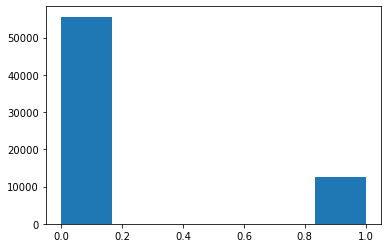

In [758]:
plt.hist(df['delay_15'], bins=6)
plt.show()

El 20% de los vuelos experimentan retraso, para poder hacer una mejor predicción habría que trabajar los datos en igualar la cantidad de puntos para cada categoría.


Me interesa entender como se distribuye la cantidad de vuelos por día. Para ello veré la frecuencia con la que ocurre cada cantidad de vuelos en el tiempo.


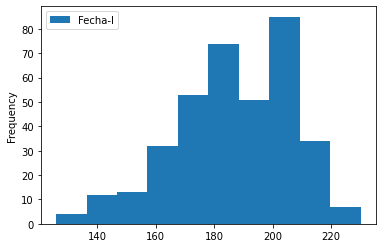

In [759]:
tab=pd.pivot_table(df, values='Fecha-I', index='Fecha-corta', aggfunc='count')
tab.plot(kind='hist', bins=10)
plt.show()


Podría ser interesante entender si la cantidad de vuelos por día se distribuyen de forma normal.

In [760]:
tab['dos']=tab['Fecha-I']
tab2=pd.pivot_table(tab, values='dos', index='Fecha-I', aggfunc='count')

stat, p=shapiro(tab2)

In [761]:
alpha = 0.05
if p > alpha:
    print('Los datos siguen una distribución normal')
else:
    print('Los datos no siguen una distribución normal')

Los datos no siguen una distribución normal


La distribución de la cantidad de viajes por día no es normal pero se aprecia que lo más común es entre 180 y 200 viajes por día.

Ahora me interesa entender que ocurre con la cantidad de vuelos retrasados más de 15 minutos por día:

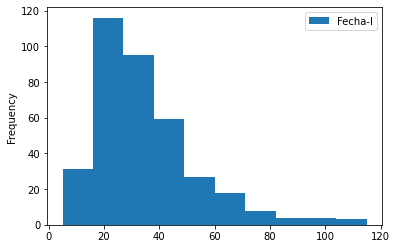

In [762]:
tab=pd.pivot_table(df[df['delay_15']==1], values='Fecha-I', index='Fecha-corta', aggfunc='count')
tab.plot(kind='hist', bins=10)
plt.show()


In [763]:
tab['dos']=tab['Fecha-I']
tab2=pd.pivot_table(tab, values='dos', index='Fecha-I', aggfunc='count')

stat, p=shapiro(tab2)
alpha = 0.05
if p > alpha:
    print('Los datos siguen una distribución normal')
else:
    print('Los datos no siguen una distribución normal')


Los datos no siguen una distribución normal


Los datos de viajes atrasados por día no siguen una distribución normal pero se ve que lo más común es entre 20 y 40 vuelos con retraso por día.

Si analizamos la distribución de la cantidad de vuelos por aerolinea veremos que 2 de ellas se llevan parte importante de los viajes, por lo que sería interesante analizar problemas separados para (LATAM,SKY) del resto.

In [764]:
df[['OPERA','period_day']].value_counts()

OPERA                     period_day
Grupo LATAM               afternoon     15290
                          morning       15112
                          night         10490
Sky Airline               morning        6284
                          afternoon      5966
                          night          2048
Copa Air                  night          1088
Aerolineas Argentinas     morning         949
American Airlines         night           757
JetSmart SPA              afternoon       621
Latin American Wings      morning         600
                          night           584
Avianca                   morning         579
Aerolineas Argentinas     night           573
Copa Air                  morning         499
Latin American Wings      afternoon       490
Gol Trans                 afternoon       448
JetSmart SPA              morning         430
Aerolineas Argentinas     afternoon       427
Avianca                   afternoon       366
Air France                afternoon       3

In [765]:
df[df['delay_15']==1][['OPERA','period_day']].value_counts()

OPERA                     period_day
Grupo LATAM               afternoon     2619
                          morning       2532
                          night         2155
Sky Airline               afternoon     1223
                          morning        815
                          night          502
Latin American Wings      night          284
Gol Trans                 afternoon      254
Latin American Wings      morning        217
Aerolineas Argentinas     night          183
Avianca                   afternoon      182
Latin American Wings      afternoon      180
Aerolineas Argentinas     morning        161
JetSmart SPA              afternoon      135
Aerolineas Argentinas     afternoon      124
Qantas Airways            afternoon      113
Avianca                   morning        112
Air Canada                afternoon       99
                          morning         81
                          night           78
Copa Air                  night           73
JetSmart SPA      

Sería interesante trabajar un modelo predictivo para Latam, un modelo para Sky y un modelo para las otras aerolineas.

Es interesante observar como para la mayoría de las aerolineas la cantidad de retrasos es muy similar en cada periodo del día, pero en Sky en la tarde es mucho mayor la cantidad de retrasos.

Una vez analizada la data, identificados ciertos comportamientos relevantes, crearé un nuevo dataframe para transformar variables sin perder las originales y así analizar la relación de las variables categoricas con el objetivo: retraso.

# Inicio Analisis de relación entre variables

Lo primero que realizaremos es transformar en ordinal las variables categoricas. Comenzaremos creando un df_2, que servirá para no perder o sobre escribir el dataframe original y así poder acudir a él en caso de ser necesario.

In [766]:
df_2=df[['delay_15','high_season','min_diff']]
df_2['Nacional_vuelo']=df['TIPOVUELO'].apply(lambda x: 0 if x=='N' else 1)
df_2['SIGLADES']=df['SIGLADES'].astype('category').cat.codes
df_2['OPERA']=df['OPERA'].astype('category').cat.codes
df_2['MES']=df['MES'].astype('category').cat.codes
df_2['DIANOM']=df['DIANOM'].astype('category').cat.codes

Me intersa comenzar entendiendo, dado que las variables son ordinales o categoricas si la prueba de indpendencia se valida o no.

Para ello comenzaremos definiendo la función chi-cuadrado:

In [767]:
def chi_cuadrado(A,B):
    observed=pd.crosstab(A['delay_15'],A[B])
    chi2, pval, dof, expected = chi2_contingency(observed)
    return B,chi2

chi_variables=dict()

nom1,chi_siglades=chi_cuadrado(df_2,'SIGLADES')
nom2,chi_aerolinea=chi_cuadrado(df_2,'OPERA')
nom3,chi_mes=chi_cuadrado(df_2,'MES')
nom4,chi_dianom=chi_cuadrado(df_2,'DIANOM')
nom5,chi_season=chi_cuadrado(df_2,'high_season')
nom6,chi_tipovuelo=chi_cuadrado(df_2,'Nacional_vuelo')

alpha=0.05

chi_variables[nom1]=[chi_siglades,chi2.ppf(1-alpha,(df_2['delay_15'].nunique()-1)*(df_2[nom1].nunique()-1))]
chi_variables[nom2]=[chi_aerolinea,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom2].nunique()-1))]
chi_variables[nom3]=[chi_mes,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom3].nunique()-1))]
chi_variables[nom4]=[chi_dianom,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom4].nunique()-1))]
chi_variables[nom5]=[chi_season,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom5].nunique()-1))]
chi_variables[nom6]=[chi_tipovuelo,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom6].nunique()-1))]

print('Coeficiente de Chi-2')
chi_variables    

Coeficiente de Chi-2


{'SIGLADES': [1895.0496794100964, 80.23209784876272],
 'OPERA': [1808.6776777045734, 33.92443847144381],
 'MES': [1184.6705611743937, 19.67513757268249],
 'DIANOM': [220.20915836952153, 12.591587243743977],
 'high_season': [29.548373218574145, 3.841458820694124],
 'Nacional_vuelo': [631.9527258893077, 3.841458820694124]}

Segun la prueba de hipotesis chi cuadrado se aprecia que todos los valores de chi cuadrado son mayores al valor critico por lo que se rechaza la hipotesis nula y se procederá a utilizar la correlación de spearman para validar si existe correlación. 

In [768]:
corr_s=df_2.corr(method="spearman")
corr_s

,delay_15,high_season,min_diff,Nacional_vuelo,SIGLADES,OPERA,MES,DIANOM
delay_15,1.000000,0.020854,0.685493,0.096295,0.036147,0.007419,0.082767,0.016064
high_season,0.020854,1.000000,0.030900,-0.001095,0.017760,-0.000267,-0.287642,0.014774
min_diff,0.685493,0.030900,1.000000,0.085308,0.079641,-0.006207,0.097479,0.023853
Nacional_vuelo,0.096295,-0.001095,0.085308,1.000000,0.144309,-0.368943,-0.012181,0.017247
SIGLADES,0.036147,0.017760,0.079641,0.144309,1.000000,0.044993,0.003965,0.006806
OPERA,0.007419,-0.000267,-0.006207,-0.368943,0.044993,1.000000,0.041071,-0.000747
MES,0.082767,-0.287642,0.097479,-0.012181,0.003965,0.041071,1.000000,0.009176
DIANOM,0.016064,0.014774,0.023853,0.017247,0.006806,-0.000747,0.009176,1.000000



Utilizaremos el p-value. Con esto podremos comparar el resultado con 0.05 y verificar si este es mayor y así rechazar la hipotesis de no relación.



In [769]:
correlation_siglades, p_value_siglades = spearmanr(df_2['delay_15'], df_2['SIGLADES'])
correlation_high_season, p_value_high_season = spearmanr(df_2['delay_15'], df_2['high_season'])
correlation_tipovuelo, p_value_tipovuelo = spearmanr(df_2['delay_15'], df_2['Nacional_vuelo'])
correlation_aerolinea, p_value_aerolinea = spearmanr(df_2['delay_15'], df_2['OPERA'])
correlation_mes, p_value_mes = spearmanr(df_2['delay_15'], df_2['MES'])
correlation_dianom, p_value_dianom = spearmanr(df_2['delay_15'], df_2['DIANOM'])


In [770]:
p_value_siglades

3.615890732692457e-21

In [771]:
p_value_high_season

5.128652537278901e-08

In [772]:
p_value_tipovuelo

3.3825228893397093e-140

In [773]:
p_value_aerolinea

0.052665857128671945

In [774]:
p_value_mes

5.755147797976886e-104

In [775]:
p_value_dianom

2.7225718331087122e-05

En geneal la dependencia entre min_diff y delay_15 es debil con las otras variables observadas. No se observa una dependencia en el comportamiento de unas con otras, aun así la variable que rechaza la hipotesis de de no correlación con el p_value es la variable OPERA correspondiente a la aerolinea.

A continuación revisaremos el coeficiente de covarianza


In [776]:
np.cov(df_2['OPERA'],df_2['delay_15'])[0][1]

0.0015774082999310192

Esto nos indica que existe una relación positiva muy debil entre las dos variables.


Analizando el VIF del modelo apra entender si existen variables repetitivas encontraremos:


In [777]:
independent_vars = ['high_season', 'Nacional_vuelo', 'SIGLADES', 'OPERA','MES','DIANOM']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns

print(vif)

   VIF Factor Independent Variable
0    1.528050          high_season
1    1.786017       Nacional_vuelo
2    2.784289             SIGLADES
3    4.779445                OPERA
4    3.215713                  MES
5    2.848158               DIANOM


Si bien las variables en general tienen una relación debil medidos con el coeficiciente de correlación Spearman, al revisar el resultado de aplicar el variance inflation factor encontramos que la más relevante debería ser "Opera": aerolinea lo que se condice con el resultado de analizar el p_value.

Con lo que se deberá cuidadosos es que este análisis es solo sobre la data originalmente incluida, ya que a continuación se añadirán nuevas variables que podrían afectar la multicolinealidad.


# Inicio construcción modelo Predictivo
    

Para hacer un modelo predictivo añadiré nuevas variables como T°, Humedad, Velocidad del viento y feriados nacionales. A continuación traigo los feriados desde un archivo que se buscó en google.

In [778]:
feriados=[]
with open('Feriados_2017.json') as archivo:
    datos = json.load(archivo)

for i in range(0,len(datos['data'])):
    feriados.append(datetime.strftime(datetime.strptime(datos['data'][i]['date'],'%Y-%m-%d'),'%d-%m-%Y'))
    

In [779]:
df_2['Fecha']=df['Fecha-I'].apply(lambda x: x.strftime('%d-%m-%Y'))
df_2['Feriado']=df_2['Fecha'].apply(lambda x: 1 if x in feriados else 0)

Ahora se cargarán las variables del clima de las cuales dejaremos solo: Fecha, Temperatura promedio, Humedad, Presión y Velocidad del viento.
    
Esta data fue obtenida desde una página de historicos de clima nacional en Google.


In [780]:
clima=pd.read_excel('clima_pudahuel.xlsx')
clima['Fecha']=clima['Fecha'].apply(lambda x: x.strftime('%d-%m-%Y'))
clima.describe()
Clima_util=clima[['Fecha','T','H','PP','V']]
df_2 = pd.merge(df_2, Clima_util, on='Fecha', how='left')

Tal como habiamos dicho, el incluir estas variables puede afectar el ejecicio, por lo que ahora quiero entender si estas variables tienen alguna relación con el objetivo



In [781]:
correlation_feriado, p_value_feriado = spearmanr(df_2['delay_15'], df_2['Feriado'])
correlation_feriado, p_value_feriado


(-0.02437808308126458, 1.9216213329595984e-10)

In [782]:
correlation_T, p_value_T = spearmanr(df_2['delay_15'], df_2['T'])
correlation_T, p_value_T


(-0.03542069505310071, 2.1766392285654072e-20)

In [783]:
correlation_H, p_value_H = spearmanr(df_2['delay_15'], df_2['H'])
correlation_H, p_value_H

(0.030369076048060557, 2.139890492742994e-15)

In [784]:
correlation_PP, p_value_PP = spearmanr(df_2['delay_15'], df_2['PP'])
correlation_PP, p_value_PP

(0.04873232850062182, 3.80746559958381e-37)

In [785]:
correlation_V, p_value_V = spearmanr(df_2['delay_15'], df_2['V'])
correlation_V, p_value_V

(0.00609104605753422, 0.11166806721561802)

La única variable de las nuevas que rechaza la hipotesis nula es la velocidad del viente. Esto podría hacer sentido dado que modifica condiciones para despegar y aterrizar.


Analicemos en VIF pero ahora con las nuevas variables:



In [786]:
independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','T','H','PP','V']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns
print(vif)


    VIF Factor Independent Variable
0     2.885507             SIGLADES
1     9.031706                OPERA
2     4.669481                  MES
3     3.192914               DIANOM
4     1.984228          high_season
5     2.125825       Nacional_vuelo
6     1.090370              Feriado
7    23.603070                    T
8     9.455506                    H
9     1.156617                   PP
10   27.039645                    V


Ahora hay variables que si podrian representar un sesgo para el objetivo como lo son el viento y T°. Quitaremos la velocidad del viento.

In [787]:
independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','T','H','PP']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns
print(vif)

   VIF Factor Independent Variable
0    2.885410             SIGLADES
1    9.019021                OPERA
2    3.758121                  MES
3    3.187571               DIANOM
4    1.982158          high_season
5    2.124306       Nacional_vuelo
6    1.089861              Feriado
7    7.410988                    T
8    9.303656                    H
9    1.134927                   PP


Removida esta variable, vemos que aún existen variables fuertemente correlacionadas. Eliminaremos la Humedad.

In [788]:
independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','T','PP']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns
print(vif)

   VIF Factor Independent Variable
0    2.829686             SIGLADES
1    6.418799                OPERA
2    3.325524                  MES
3    2.977631               DIANOM
4    1.980665          high_season
5    1.901595       Nacional_vuelo
6    1.083760              Feriado
7    7.346004                    T
8    1.078084                   PP


La variable T° tambien será removida para respetar el treshold de 5

In [789]:
independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','PP']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns
print(vif)

   VIF Factor Independent Variable
0    2.785326             SIGLADES
1    4.814715                OPERA
2    3.263136                  MES
3    2.872459               DIANOM
4    1.547991          high_season
5    1.790997       Nacional_vuelo
6    1.083278              Feriado
7    1.061867                   PP


Ahora no existen variables repetitivas. Procederemos a avanzar con la data.


Algo que habiamos Observado es el imbalance en nuestra variable objetivo a nivel de categorías, 80% Sin retraso y 20% con retraso. Para trabajar la data comenzaremos por balancear el N° de registros para cada categoría a predecir.

Para ello utilizaremos un downsampling, igualando la muestra mayor a la de menor tamaño.

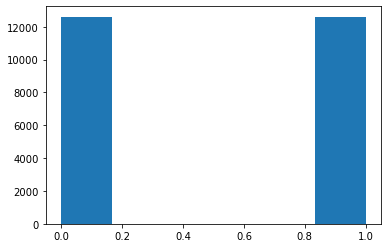

In [790]:
Sinatraso = df_2[df_2['delay_15'] == 0]
Conatraso = df_2[df_2['delay_15'] == 1]

numero_de_registros_con_retraso=len(Conatraso)
Sinatraso_balanceado=Sinatraso.sample(numero_de_registros_con_retraso)
df_2_balanceado=pd.concat([Sinatraso_balanceado,Conatraso])
df_2_balanceado = df_2_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)
plt.hist(df_2_balanceado['delay_15'], bins=6)
plt.show()

Ahora se puede apreciar que ambas muestras tienen la misma cantidad de registros.

Comienza construcción de modelo en Catboost.

In [791]:
X = df_2_balanceado[['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','PP']]
y = df_2_balanceado['delay_15']

In [792]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [793]:
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', random_state=42,eval_metric='F1')
cat_model.fit(X_train, y_train, verbose=False)

In [794]:
y_pred = cat_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62      2558
           1       0.62      0.71      0.66      2488

    accuracy                           0.64      5046
   macro avg       0.65      0.64      0.64      5046
weighted avg       0.65      0.64      0.64      5046



In [795]:
scores = cross_val_score(cat_model, X, y, cv=25)

0:	learn: 0.6367629	total: 3.91ms	remaining: 387ms
1:	learn: 0.6423906	total: 8.15ms	remaining: 399ms
2:	learn: 0.6337474	total: 11.6ms	remaining: 374ms
3:	learn: 0.6360210	total: 15.2ms	remaining: 364ms
4:	learn: 0.6406503	total: 18.8ms	remaining: 357ms
5:	learn: 0.6420678	total: 22.5ms	remaining: 353ms
6:	learn: 0.6399813	total: 26.3ms	remaining: 350ms
7:	learn: 0.6433599	total: 30.6ms	remaining: 352ms
8:	learn: 0.6452014	total: 33.6ms	remaining: 340ms
9:	learn: 0.6475031	total: 38.4ms	remaining: 346ms
10:	learn: 0.6483449	total: 42.2ms	remaining: 341ms
11:	learn: 0.6455676	total: 46ms	remaining: 338ms
12:	learn: 0.6496495	total: 49.2ms	remaining: 329ms
13:	learn: 0.6514458	total: 53.2ms	remaining: 327ms
14:	learn: 0.6518919	total: 56.4ms	remaining: 320ms
15:	learn: 0.6524608	total: 59.6ms	remaining: 313ms
16:	learn: 0.6513347	total: 62.7ms	remaining: 306ms
17:	learn: 0.6504691	total: 65.9ms	remaining: 300ms
18:	learn: 0.6539061	total: 69.5ms	remaining: 296ms
19:	learn: 0.6534971	tot

In [796]:
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.642 (+/- 0.03)


In [797]:
y_prob=cat_model.predict_proba(X_test)[:,1]
area_bajo_la_curva=roc_auc_score(y_test,y_prob)
area_bajo_la_curva

0.6937824623085258

Entendiendo que en la industria de viajes comerciales la planificación correcta del itinerario de los vuelos puede tener
un fuerte impacto sobre el negocio y posibles multas que se puedan generar por mala planificación, es importante que los 
modelos sean lo más precisos posibles, pero además, nos debe preocupar que los falsos positivos y falsos negativos sean
los menos posibles para no generar problemas de planificación. Entonces, el accuracy nos permitirá entender la eficacia
del modelo para predecir, pero además en Recall (casos correctamente clasificados de cada categoria) nos permitirá
entender la capacidad del modelo para predecir Trupositives y el f1-score como medida para la predicción de ambas clases.
El área bajo la curva es igualmente interesante para data imbalanceada ya que nos permite entender que tan bien generaliza
nuestro modelo respecto del azar. En este caso, nuestro modelo es moderadamente aceptable respecto del azar, con un accuracy
moderadamente más alto que el azar. Accuracy=64%. Auc_Roc=69%. El f1-score de 1 es 64%.

Entonces si queremos entender que variables fueron relevantes para este resultado hacemos lo siguiente:

In [798]:
feature_importances = cat_model.get_feature_importance()


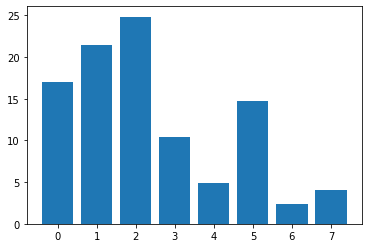

In [799]:
plt.bar(range(len(feature_importances)), feature_importances)
plt.show()

In [800]:
print(feature_importances)

[17.01135648 21.49933274 24.85256099 10.43699476  4.94274597 14.7463224
  2.41171659  4.09897008]


In [801]:
print(X.columns)

Index(['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo',
       'Feriado', 'PP'],
      dtype='object')


Las variables mas relevantes en este modelo fueron: La aerolinea, el mes, si era vuelo nacional o internacional y el destino.


Dado que el resultado no es óptimo (Esperariamos mejor precisión), buscaremos mejorarlo por medio de optuna:


In [802]:
def objective(trial):
    # Definir los hiperparámetros que se optimizarán
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }
    
    # Crear modelo de CatBoostClassifier con los hiperparámetros seleccionados
    cat_model_optuna = CatBoostClassifier(**params, random_seed=42, verbose=False,eval_metric='F1')
    
    # Entrenar el modelo
    cat_model_optuna.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Evaluar el modelo en el conjunto de prueba
    score = cat_model_optuna.score(X_test, y_test)
    
    return score

# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')

# Ejecutar la optimización de los hiperparámetros
study.optimize(objective, n_trials=10)

# Imprimir los mejores hiperparámetros y puntuación
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2023-03-31 17:45:37,502] A new study created in memory with name: no-name-4dc569e6-e8a7-4d51-bafa-3e5d23974dd8
[I 2023-03-31 17:46:04,599] Trial 0 finished with value: 0.6468489892984542 and parameters: {'iterations': 1102, 'learning_rate': 0.1991826837112063, 'depth': 10, 'l2_leaf_reg': 3.5793242348347043, 'border_count': 244}. Best is trial 0 with value: 0.6468489892984542.
[I 2023-03-31 17:46:25,414] Trial 1 finished with value: 0.6420927467300832 and parameters: {'iterations': 1872, 'learning_rate': 0.09745059325852146, 'depth': 7, 'l2_leaf_reg': 8.024992126275933, 'border_count': 221}. Best is trial 0 with value: 0.6468489892984542.
[I 2023-03-31 17:46:33,185] Trial 2 finished with value: 0.644867221561633 and parameters: {'iterations': 916, 'learning_rate': 0.4897438262363782, 'depth': 5, 'l2_leaf_reg': 9.477488658047404, 'border_count': 184}. Best is trial 0 with value: 0.6468489892984542.
[I 2023-03-31 17:46:38,502] Trial 3 finished with value: 0.6474435196195006 and paramet

Best trial: {'iterations': 941, 'learning_rate': 0.19825160714844656, 'depth': 7, 'l2_leaf_reg': 6.5876175121865215, 'border_count': 76}
Best score: 0.6484344034879113


El modelo se puede mejorar utilizando técnicas de hiperparametrización como greedsearch u Optuna (como se hizo en este caso para pocos casos de estudio). Tambien podría ser por medio de explorar en lugar de utilizar undersampling utilizar oversampling o bien aumentar la muestra o utilizar otros modelos como podría ser XGBoost, randomforest, etc.

Con los resultados obtenidos: 0.5% de mejoría, el uso de optuna no es recomendable ya que aumenta los tiempos y los costos y mejora levemente los resultados. Sería más recomendable probar con otros modelos o, probar modelos para grupos de Aerolineas.

Haremos una prueba con XGBoost para comparar el rendimiento de los modelos

Previamente cargaremos la métrica f1-score para hacer la comparativo de ambos modelos bajo el mismo indicador.

In [803]:
def f1_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred)

In [804]:
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'n_estimators': 1000
}


xgb_model = xgb.XGBClassifier(**params,eval_metric=f1_metric)
xgb_model.fit(X_train, y_train)

# Predecir sobre los datos de prueba
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[1641  917]
 [ 945 1543]]


In [805]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64      2558
           1       0.63      0.62      0.62      2488

    accuracy                           0.63      5046
   macro avg       0.63      0.63      0.63      5046
weighted avg       0.63      0.63      0.63      5046



In [806]:
print("AUC: ", roc_auc_score(y_test, y_pred))

AUC:  0.6308468294412083


In [807]:
scores_xgb = cross_val_score(xgb_model, X, y, cv=25)

In [808]:
print("Accuracy: %0.3f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Accuracy: 0.638 (+/- 0.03)


El resultado base de XGBoost nos entrega un resultado similar al de Catboos, veamos que pasa si usamos optuna en este caso:

In [809]:
# Definir función objetivo para optimización de hiperparámetros de XGBoost

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    # Entrenar modelo XGBoost
    xgb_op_model = xgb.XGBClassifier(**params)
    xgb_op_model.fit(X_train, y_train)

    # Calcular puntuación de prueba F1-score
    score = f1_score(y_test, xgb_op_model.predict(X_test))
    return score

# Optimizar hiperparámetros con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Imprimir mejores parámetros y puntuación F1-score
best_params = study.best_params
best_score = study.best_value
print(f"Mejores parámetros: {best_params}")
print(f"Puntuación F1-score: {best_score}")

[I 2023-03-31 17:50:56,208] A new study created in memory with name: no-name-25f12e4d-07c3-4958-94c2-67de05c1dc0c
[I 2023-03-31 17:50:59,137] Trial 0 finished with value: 0.6366533864541832 and parameters: {'n_estimators': 318, 'max_depth': 10, 'learning_rate': 0.03806045277609187, 'subsample': 0.6235583829058533, 'colsample_bytree': 0.74194179565847, 'gamma': 0.00034181600943019246, 'min_child_weight': 10}. Best is trial 0 with value: 0.6366533864541832.
[I 2023-03-31 17:51:02,839] Trial 1 finished with value: 0.6291909255169645 and parameters: {'n_estimators': 547, 'max_depth': 7, 'learning_rate': 0.08308292208646795, 'subsample': 0.6156760017912155, 'colsample_bytree': 0.6648790781674618, 'gamma': 0.001353623023878703, 'min_child_weight': 6}. Best is trial 0 with value: 0.6366533864541832.
[I 2023-03-31 17:51:06,305] Trial 2 finished with value: 0.6315369261477045 and parameters: {'n_estimators': 365, 'max_depth': 9, 'learning_rate': 0.0323000324795295, 'subsample': 0.72503558718822

Mejores parámetros: {'n_estimators': 144, 'max_depth': 7, 'learning_rate': 0.01179635484502505, 'subsample': 0.5450746620820193, 'colsample_bytree': 0.6195064805326187, 'gamma': 1.0331558328336903e-06, 'min_child_weight': 10}
Puntuación F1-score: 0.6556630620375641


En este caso para XGboost mejoró los resultados con Optuna, aumentando el F1-score en 2% hasta un 66%.

Ahora podríamos probar un modelo de Ensamble entre los modelos que creamos:
    
Para ello creamos el modelo de ensamble utilizando la votación de las predicciones.

In [831]:
ensemble_preds = np.round((xgb_model.predict_proba(X_test)[:, 1] + cat_model.predict_proba(X_test)[:, 1]) / 2)
ensemble_auc = f1_score(y_test, ensemble_preds)
print('Ensamble F1:', ensemble_auc)

Ensamble F1: 0.6282225237449117


El ensamble no mejora los resultados de la predicción anterior. Sería, en mi opinión mejor utilizar el modelo XGBoost con optuna ya que es más preciso respecto del resultado de Catboost con Optuna.

Aun así, se podría seguir aplicando Optuna o probando más modelos y parámetros.

En este caso, probaremos con otro modelo. Veremos que ocurre con los resultados al intentar predecir solo para Latam.

Solo para Latam (12) dado que tiene mucho volumen de viajes.

Utilizaremos un df_3 para no perder la base del modelo anterior, pero tambien dado que filtraremos por OPERA==12 que corresponde a Latam.

Añadiremos la variable Periodo del día y resolveremos posibles problemas de imbalance que puedan existir.

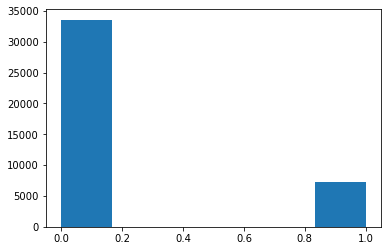

In [811]:
#Añadiré el momento del día:
df_2['Rango_dia']=df['period_day'].astype('category').cat.codes
df_3=df_2[df_2['OPERA']==12]
plt.hist(df_3['delay_15'], bins=6)
plt.show()

Podemos ver que las categorías están imbalanceadas. Lo resolveremos:

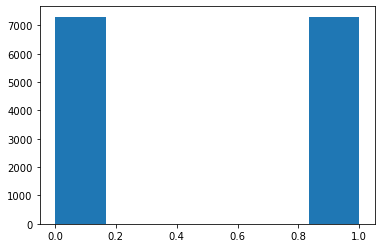

In [812]:
Sinatraso = df_3[df_3['delay_15'] == 0]
Conatraso = df_3[df_3['delay_15'] == 1]

numero_de_registros_con_retraso=len(Conatraso)
Sinatraso_balanceado=Sinatraso.sample(numero_de_registros_con_retraso)
df_2_balanceado=pd.concat([Sinatraso_balanceado,Conatraso])
df_2_balanceado = df_2_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)
plt.hist(df_2_balanceado['delay_15'], bins=6)
plt.show()

Ahora están equitativos.

Revisaremos sobre la data filtrada la importancia de las variables.

In [813]:
independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','PP','Rango_dia']
X = df_3[independent_vars]
y = df_3['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns
print(vif)

   VIF Factor Independent Variable
0    1.060774             SIGLADES
1   10.595072                OPERA
2    1.120154                  MES
3    1.009509               DIANOM
4    1.129896          high_season
5    1.074242       Nacional_vuelo
6    1.018253              Feriado
7    1.016931                   PP
8    1.024642            Rango_dia


Deberemos retirar la variable OPERA

In [814]:
independent_vars = ['SIGLADES', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','PP','Rango_dia']
X = df_3[independent_vars]
y = df_3['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns
print(vif)

   VIF Factor Independent Variable
0    2.597312             SIGLADES
1    2.633774                  MES
2    2.588904               DIANOM
3    1.466913          high_season
4    1.826564       Nacional_vuelo
5    1.075732              Feriado
6    1.056747                   PP
7    2.033494            Rango_dia


Ahora tenemos la data balanceada y con las variables correctas.

In [815]:
X_latam = df_2_balanceado[['SIGLADES', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','PP','Rango_dia']]
y_latam = df_2_balanceado['delay_15']

In [816]:
X_train, X_test, y_train, y_test = train_test_split(X_latam, y_latam, test_size=0.2, random_state=42)

In [817]:
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', random_state=42,eval_metric='F1')
cat_model.fit(X_train, y_train, verbose=False)

In [818]:
y_pred = cat_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62      1427
           1       0.64      0.64      0.64      1496

    accuracy                           0.63      2923
   macro avg       0.63      0.63      0.63      2923
weighted avg       0.63      0.63      0.63      2923



In [819]:
scores = cross_val_score(cat_model, X_latam, y_latam, cv=25)

0:	learn: 0.6210512	total: 3.4ms	remaining: 337ms
1:	learn: 0.6380602	total: 8.21ms	remaining: 402ms
2:	learn: 0.6392526	total: 12.3ms	remaining: 396ms
3:	learn: 0.6341008	total: 14.9ms	remaining: 358ms
4:	learn: 0.6338375	total: 17.5ms	remaining: 333ms
5:	learn: 0.6300797	total: 20ms	remaining: 313ms
6:	learn: 0.6282651	total: 23.7ms	remaining: 315ms
7:	learn: 0.6356051	total: 26.8ms	remaining: 309ms
8:	learn: 0.6384590	total: 29.7ms	remaining: 301ms
9:	learn: 0.6401064	total: 33.3ms	remaining: 299ms
10:	learn: 0.6433492	total: 36ms	remaining: 292ms
11:	learn: 0.6437734	total: 39.7ms	remaining: 291ms
12:	learn: 0.6436643	total: 42.8ms	remaining: 287ms
13:	learn: 0.6422879	total: 46.3ms	remaining: 284ms
14:	learn: 0.6417609	total: 49ms	remaining: 278ms
15:	learn: 0.6405713	total: 52.9ms	remaining: 278ms
16:	learn: 0.6390677	total: 56.3ms	remaining: 275ms
17:	learn: 0.6381037	total: 59.4ms	remaining: 271ms
18:	learn: 0.6403366	total: 62.8ms	remaining: 268ms
19:	learn: 0.6422528	total: 6

In [820]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.04)


Haremos una prueba con XGBoost solo para Latam

In [821]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': f1_metric,
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'n_estimators': 1000
}


xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

# Predecir sobre los datos de prueba
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[902 525]
 [591 905]]


In [822]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62      1427
           1       0.63      0.60      0.62      1496

    accuracy                           0.62      2923
   macro avg       0.62      0.62      0.62      2923
weighted avg       0.62      0.62      0.62      2923



In [823]:
print("AUC: ", roc_auc_score(y_test, y_pred))

AUC:  0.618520914449745


In [824]:
scores = cross_val_score(xgb_model, X_latam, y_latam, cv=25)

In [825]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.03)


Ahora podríamos probar un modelo de Ensamble entre los modelos Latam que creamos


Crear el modelo de ensamble utilizando la votación de las predicciones

In [826]:
ensemble_preds = np.round((xgb_model.predict_proba(X_test)[:, 1] + cat_model.predict_proba(X_test)[:, 1]) / 2)
ensemble_auc = f1_score(y_test, ensemble_preds)
print('Ensamble F1-Score:', ensemble_auc)

Ensamble F1-Score: 0.6282225237449117


In [827]:
feature_importances_cat = cat_model.get_feature_importance()
feature_importances_xgb = xgb_model.feature_importances_


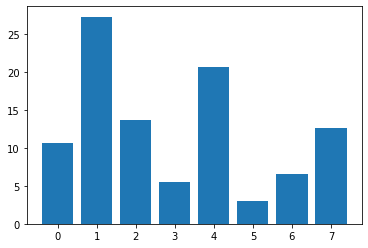

In [828]:
plt.bar(range(len(feature_importances_cat)), feature_importances_cat)
plt.show()

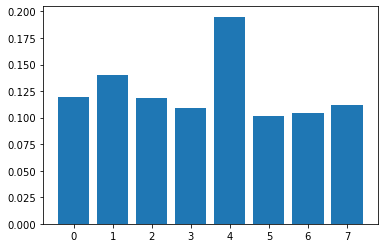

In [829]:
plt.bar(range(len(feature_importances_xgb)), feature_importances_xgb)
plt.show()

In [830]:
print(X_latam.columns)

Index(['SIGLADES', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo', 'Feriado',
       'PP', 'Rango_dia'],
      dtype='object')


Vemos entonces que al analizar solo Latam obtenemos peores resultados que si analizamos el problema de manera genérica, pero esto no sería concluyente del todo ya que no hemos analizado como generaliza solo para Latam en modelo general, sino para todas las aerolineas. Para llegar a una mejor conclusión, se podría trabajar en modelos para Latam, SKY y las otras aerolineas y contrastarlo con la capacidad de predecir del modelo general en cada uno de esos casos. 